In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py

import numpy as np
import pandas as pd

import glob

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [3]:
def plot_wavefields(preds, trues, errors,timestep_to_plot,name_to_save=None):
    fig , axs = plt.subplots(3,len(timestep_to_plot),figsize=(len(timestep_to_plot)*2.7,7.5),squeeze=False)

    for row, ts in enumerate(timestep_to_plot):

        # True
        im_true = axs[1,row].imshow(trues[row,:,:],norm=MidpointNormalize(midpoint=0,vmin=trues.min(),vmax=trues.max()))
        clim = im_true.get_clim()

        # Predictions
        im_pred = axs[0,row].imshow(preds[row,:,:],norm=MidpointNormalize(midpoint=0),clim=clim)
        axs[0,row].set_title(f'Wavefield {ts}',fontsize=16)

        # Error
        im_error = axs[2,row].imshow(errors[row,:,:],norm=MidpointNormalize(midpoint=0,vmin=errors.min(),vmax=errors.max()))

        axs[0,row].tick_params(left=False,bottom=False)
        axs[0,row].set(yticklabels=[],xticklabels=[])
        axs[0,row].set_frame_on(False)
        axs[1,row].tick_params(left=False,bottom=False)
        axs[1,row].set(yticklabels=[],xticklabels=[])
        axs[1,row].set_frame_on(False)
        axs[2,row].tick_params(left=False,bottom=False)
        axs[2,row].set(yticklabels=[],xticklabels=[])
        axs[2,row].set_frame_on(False)

        axs[0,0].set_ylabel('Prediction',fontsize=16)
        axs[1,0].set_ylabel('True',fontsize=16)
        axs[2,0].set_ylabel('Error',fontsize=16)
    
    plt.tight_layout()
    
    # Colorbar
    divider = make_axes_locatable(axs[1,-1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im_true, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)

    divider = make_axes_locatable(axs[0,-1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im_pred, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)

    divider = make_axes_locatable(axs[2,-1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im_error, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)

    if name_to_save:
        plt.savefig(name_to_save,dpi=600,bbox_inches='tight')

In [4]:
error = np.load('models_output/unet_errors_PINN_RES_E500.npy')
trues = np.load('models_output/unet_trues_PINN_RES_E500.npy')
preds = np.load('models_output/unet_preds_PINN_RES_E500.npy')

#plot_wavefields(preds, trues, error, [0,25,50,100,150],name_to_save='training_layered.pdf')

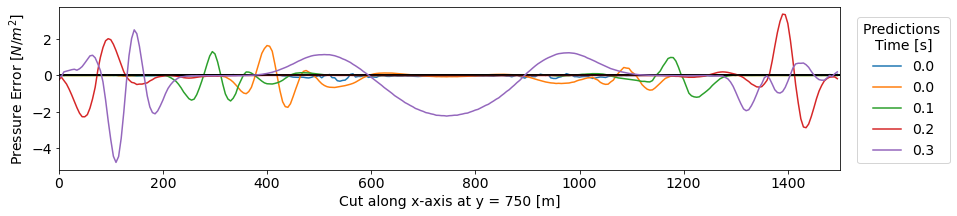

In [5]:
fig, ax = plt.subplots(figsize=(14,3))
for i, ts in enumerate([0,25,50,100,150]):
    ax.plot([0,1500],[0,0],'k')
    ax.plot(list(range(0,1500,5)),error[i,150,:],label=f'{np.round(ts*0.002,1)}')
    ax.set_xlim(0,1500)
    ax.set_xlabel('Cut along x-axis at y = 750 [m]',fontsize = 14)
    ax.set_ylabel('Pressure Error $[N/m^2]$',fontsize = 14)
    ax.tick_params(axis='both', labelsize=14)

    leg = ax.legend(bbox_to_anchor=(1.15,0.98),loc='upper right',fontsize=14)
    leg.set_title("Predictions \nTime [s]",prop={'size':14})
    plt.setp(leg.get_title(), multialignment='center')
#plt.savefig('training_layered_unet_wavefields_error.pdf',dpi=600,bbox_inches='tight')

[0, 5]
[1, 4]
[2, 3]
[6, 7]


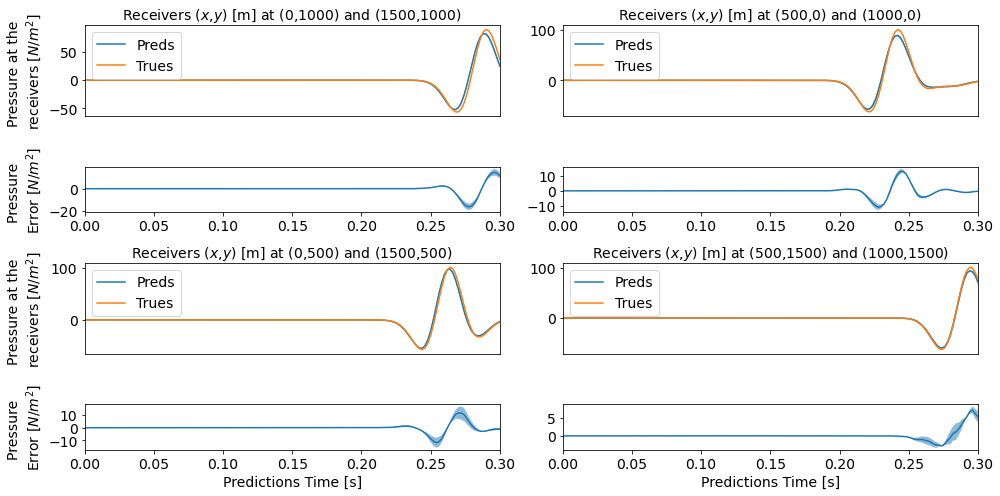

In [6]:
model_name = 'models_output/unet_PINN_RES_E500.csv'

df_preds = pd.read_csv(model_name,index_col=0,usecols=['time','receivers_pred'])['receivers_pred'].str.replace(']','').str.replace('[','').str.replace('\n','').str.rstrip().str.lstrip().str.split('\s+',expand=True).astype(float)
df_trues = pd.read_csv(model_name,index_col=0,usecols=['time','receivers_true'])['receivers_true'].str.replace(']','').str.replace('[','').str.replace('\n','').str.rstrip().str.lstrip().str.split('\s+',expand=True).astype(float)

pairs = [[0,5],[1,4],[2,3],[6,7]]
pairs_location = [['0,1000','1500,1000'],['0,500','1500,500'],['500,0','1000,0'],['500,1500','1000,1500']]

fig = plt.figure(figsize=(14,7))

spec = gridspec.GridSpec(ncols=2, nrows=4, height_ratios=[2, 1, 2, 1])

pair = 0
for col in range(2):
    for i, row in enumerate(range(0,4,2)):
        print(pairs[pair])  

        df_pair_preds = df_preds.loc[:,pairs[pair]]
        df_pair_trues = df_trues.loc[:,pairs[pair]]

        ax0 = fig.add_subplot(spec[row,col])
        ax0.fill_between(df_pair_preds.index,df_pair_preds.max(axis=1),df_pair_preds.min(axis=1),alpha=0.5)
        ax0.plot(df_pair_preds.index,df_pair_preds.mean(axis=1),label='Preds')

        ax0.fill_between(df_pair_trues.index,df_pair_trues.max(axis=1),df_pair_trues.min(axis=1),alpha=0.5)
        ax0.plot(df_pair_trues.index,df_pair_trues.mean(axis=1),label='Trues')
        ax0.tick_params(axis='both', labelsize=14)

        ax0.set_title(f'Receivers ($x$,$y$) [m] at ({pairs_location[pair][0]}) and ({pairs_location[pair][1]})',fontsize = 14)
        if col < 1:
            ax0.set_ylabel('Pressure at the \nreceivers $[N/m^2]$',fontsize = 14)
        ax0.legend(fontsize = 14)
        ax0.set_xticks([])
        ax0.set_xlim(0,0.3)

        ax1 = fig.add_subplot(spec[row+1,col])
        ax1.plot(df_pair_preds.index,(df_pair_trues-df_pair_preds).mean(axis=1))
        ax1.fill_between(df_pair_preds.index,(df_pair_trues-df_pair_preds).min(axis=1),(df_pair_trues-df_pair_preds).max(axis=1),alpha=0.5)
        if col < 1:
            ax1.set_ylabel('Pressure \nError $[N/m^2]$',fontsize = 14)
        if row > 0:
            ax1.set_xlabel('Predictions Time [s]',fontsize = 14)
        ax1.set_xlim(0,0.3)
        ax1.tick_params(axis='both', labelsize=14)

        pair += 1

fig.align_ylabels()
plt.tight_layout()
#plt.savefig('training_layered_unet_receivers.pdf',dpi=600,bbox_inches='tight')

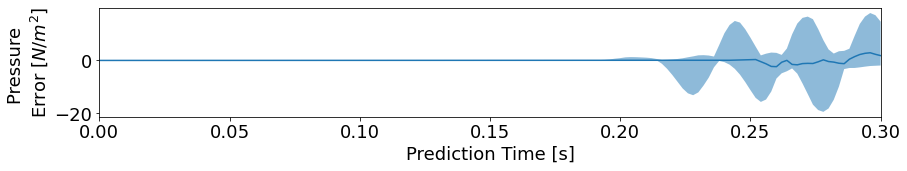

In [7]:
model_name = 'models_output/unet_PINN_RES_E500.csv'

df_preds = pd.read_csv(model_name,index_col=0,usecols=['time','receivers_pred'])['receivers_pred'].str.replace(']','').str.replace('[','').str.replace('\n','').str.rstrip().str.lstrip().str.split('\s+',expand=True).astype(float)
df_trues = pd.read_csv(model_name,index_col=0,usecols=['time','receivers_true'])['receivers_true'].str.replace(']','').str.replace('[','').str.replace('\n','').str.rstrip().str.lstrip().str.split('\s+',expand=True).astype(float)

fig, ax = plt.subplots(figsize=(14,2))
ax.plot(df_preds.index,(df_trues-df_preds).median(axis=1))
ax.fill_between(df_preds.index,(df_trues-df_preds).min(axis=1),(df_trues-df_preds).max(axis=1),alpha=0.5)
ax.set_ylabel('Pressure \nError $[N/m^2]$',fontsize = 18)
ax.set_xlabel('Prediction Time [s]',fontsize = 18)
ax.set_xlim(0,0.3)
ax.tick_params(axis='both', labelsize=18)
plt.savefig('training_layered_unet_receivers_error.pdf',bbox_inches='tight')

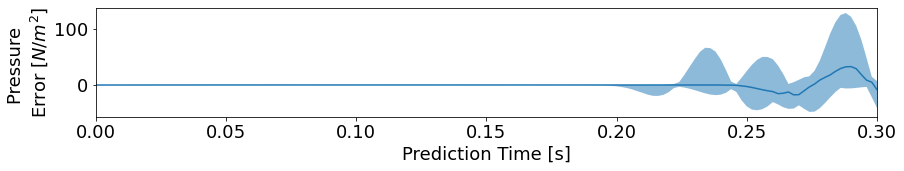

In [8]:
model_name = 'models_output/encoder_L2_GDL_MAE_E500.csv'

df_preds = pd.read_csv(model_name,index_col=0,usecols=['time','receivers_pred'])['receivers_pred'].str.replace(']','').str.replace('[','').str.replace('\n','').str.rstrip().str.lstrip().str.split('\s+',expand=True).astype(float)
df_trues = pd.read_csv(model_name,index_col=0,usecols=['time','receivers_true'])['receivers_true'].str.replace(']','').str.replace('[','').str.replace('\n','').str.rstrip().str.lstrip().str.split('\s+',expand=True).astype(float)

fig, ax = plt.subplots(figsize=(14,2))
ax.plot(df_preds.index,(df_trues-df_preds).median(axis=1))
ax.fill_between(df_preds.index,(df_trues-df_preds).min(axis=1),(df_trues-df_preds).max(axis=1),alpha=0.5)
ax.set_ylabel('Pressure \nError $[N/m^2]$',fontsize = 18)
ax.set_xlabel('Prediction Time [s]',fontsize = 18)
ax.set_xlim(0,0.3)
ax.tick_params(axis='both', labelsize=18)
plt.savefig('training_layered_encoder_receivers_error.pdf',dpi=600,bbox_inches='tight')

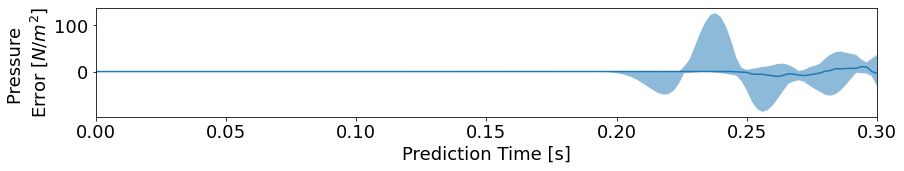

In [9]:
model_name = 'models_output/multiscale_PINN_RES_E500.csv'

df_preds = pd.read_csv(model_name,index_col=0,usecols=['time','receivers_pred'])['receivers_pred'].str.replace(']','').str.replace('[','').str.replace('\n','').str.rstrip().str.lstrip().str.split('\s+',expand=True).astype(float)
df_trues = pd.read_csv(model_name,index_col=0,usecols=['time','receivers_true'])['receivers_true'].str.replace(']','').str.replace('[','').str.replace('\n','').str.rstrip().str.lstrip().str.split('\s+',expand=True).astype(float)

fig, ax = plt.subplots(figsize=(14,2))
ax.plot(df_preds.index,(df_trues-df_preds).median(axis=1))
ax.fill_between(df_preds.index,(df_trues-df_preds).min(axis=1),(df_trues-df_preds).max(axis=1),alpha=0.5)
ax.set_ylabel('Pressure \nError $[N/m^2]$',fontsize = 18)
ax.set_xlabel('Prediction Time [s]',fontsize = 18)
ax.set_xlim(0,0.3)
ax.tick_params(axis='both', labelsize=18)
plt.savefig('training_layered_multiscale_receivers_error.pdf',dpi=600,bbox_inches='tight')